# Graphs in bioinformatics
## Final project: Hierarchy in random graphs
### Statement of the problem
Consider an Erdős–Rényi (E-R) directed graph around the critical point of percolation. 
Before the critcial point there is many small strongly connected components. Exactly at the percolation point the structure of the giant component in the E-R is tree like. Finally after the critical point in the percolation the giant component will _absorb_ all the small components.

Trees are highly hierarchical objects is natural to ask if the E-R graph will show a peak for the appropiate hierarchical measures. 

The following measures will be considered:

*  the fraction of links not participating in any directed cycles,
*  the Global Reaching Centrality introduced in E. Mones, L. Vicsek and T. Vicsek, [Hierarchy measure for complex networks.](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0033799) PLoS ONE 7, e33799 (2012).

### Proposed solution to the problem

I designed a numerical solution to inspect the appereance of a peak in the measures around the percolation limit.
The following code will make use of the [Networkx v2.4](https://networkx.github.io/documentation/stable/index.html) module for Python. 

I will compute the values for this measures around a symmetric interval centered in the theoretical estimation for the percolation point $\langle k\rangle=1$. This is the point when the relative size of the giant component starts increasing accordingly to the equation $S \approx 1 − e^{−\langle k\rangle S}$. For a directed E-R graph the average degree is $\langle k\rangle \approx Np$ for large $N$, when $N$ is the number of nodes in the graph and $p$ is the probability of edge creation.

### Details of the numerical exploration
Parameters to control the numerical inspection.

* __N__ nodes in the E-R graph.
* __p__ probability of edge creation.
* __interval__ is the size of the symmetric interval around the percolation point.
* __num\_points__ number of points to show in the graph.
* __sample\_size__ number of graphs to produce an ensemble of graphs.

The numerical exploration will compute four attributes from the any graph. These attributes are:
* Relative degree of the giant component.
* Fraction of edges not participating in any directed cycle.
* Average degree of the graph.
* Global reaching centrality.

These attributes will ve average over an ensemble of graphs. Each graph will have the same N and p values, this will reduce the fluctuations in the result due to the randomness of the E-R graph. To explore the sorroundings of the percolation point we produce several points to reconstruct a curve for each one of the measures with respect to p, given constant N.

In [37]:
#Import the necessary modules for the project.
import networkx as nx
import matplotlib.pyplot as plt

Initilaize the parameters and create 4 lists. This lists will be used for save the results of the numerical exploration. 

In [38]:
rel_s = []
ed_no_cycle = []
mean_d = []
glo_cen = []
num_nodes = 200
inv_nodes = 1/num_nodes
interval = 0.9
ini = inv_nodes-interval*inv_nodes
num_points = 20
fin = inv_nodes+interval*inv_nodes
sample_size = 20
interval = 0.9

Now it's time to create appropiate functions. The technicalities for each function are described within themselves.

In [39]:
def rel_size_giant(Gr):
    '''
    Parameters
    ----------
    Gr : A directed graph.

    Returns
    -------
    rel_giant_size : float
    Relative size of the largest strongly
    connected component
    '''
    num_n = Gr.number_of_nodes()
    #Uses Tarjan's algorithm to find 
    #the strongly connected components
    con_comp_it = nx.strongly_connected_components(Gr)
    largest = len(max(con_comp_it, key=len))
    rel_giant_size = largest/num_n
    return rel_giant_size

The number of edges no participating in any cycle is equivalent to look for all the bridges in the graph. Using the strongly connected decomposition we can isolate the nodes no participating in cycles. This will be done using [Tarjan's algorithm](https://en.wikipedia.org/wiki/Tarjan%27s_strongly_connected_components_algorithm). This algorithm runs in $O\left( |V|+|E| \right)$, considering that the expected number of edges for the E-R graph is $\binom{N}{2}p$; the running time can be estimated to be $O\left(|V|^2 \right)$.

In [40]:
def num_ed_no_cycle(Gr):
    '''
    Parameters
    ----------
    Gr : A directed graph.

    Returns
    -------
    ed_num_nocy : float
    Frequency of edges not participating
    in any cycle
    '''
    con_comp_it = nx.strongly_connected_components(Gr)
    num_edges = Gr.number_of_nodes()
    con_edges = 0
    #Construct a subgraph for any connected component
    #Compute the number of edges in any connected component
    for h in con_comp_it:
        con_edges += Gr.subgraph(h).number_of_edges()
    #Frecueny of edges no participating in any cycle
    ed_num_nocy = (num_edges - con_edges)/num_edges
    return ed_num_nocy

To construct the local centrality measure I implemented first a function to calculate the local reaching centrality. This function exploits the [Breadth-first search](https://en.wikipedia.org/wiki/Breadth-first_search) method implemented in Networkx module. This method has a runnig time of $O\left(|V|^2 \right)$ in our particular graph. Then we loop through all the nodes in the graph to estimate the global reaching centrality. It is worth to mention that Networkx has a function that produces the same results as reported here. Looking in the source code of [networkx.algorithms.global_reaching_centrality](https://networkx.github.io/documentation/stable/_modules/networkx/algorithms/centrality/reaching.html#global_reaching_centrality) this method finds the shortest path to compute all the nodes to reach from a single vertex $i$. Based on the [shortest path problem](https://en.wikipedia.org/wiki/Shortest_path_problem#Algorithms) the running time for solve this problem will be always bigger than $O\left(|V|^2 \right)$ for E-R graphs. This is the main reason to implement my own functions.

In [41]:
def local_centrality(Gr,v):
    '''
    Parameters
    ----------
    Gr : A directed graph.
    v : A root node to compute
    the local centrality measure

    Returns
    -------
    aux_loc_cen : float
    Local centrality measure
    '''
    num_n = Gr.number_of_nodes()
    #Use the Breath first-search to investigate
    #all the edges connected with node v
    edges = nx.bfs_edges(Gr, v)
    #Compute nodes from edges
    nodes = [v] + [k for u, k in edges]
    num_nodes = len(nodes)
    return num_nodes/num_n

def global_centrality(Gr):
    '''
    Parameters
    ----------
    Gr : A directed graph.

    Returns
    -------
    ax_glo_cent : float
    Global reaching centrality
    '''
    num_n = Gr.number_of_nodes()
    loc_cen_array = []
    #Compute the local centrality measure
    #for all the nodes in the graph
    for i in range(num_n):
        loc_cen_array.append(local_centrality(Gr, i))
    max_cen = max(loc_cen_array)
    uni_loc = [max_cen - k for k in loc_cen_array]
    return sum(uni_loc)/(num_n-1)

Create a nested loop to modify the probablity of links in the E-R graph. For each new value of p, we average over the ensemble and save the values.

In [42]:
for i in [ini+i*((fin-ini)/num_points) for i in range(num_points+1)]:
    #Create auxiliary list to save the values of metrics
    #for all the graphs in the ensemble
    aux_mean_deg = []
    aux_rel_g_sz = []
    aux_glo = []
    aux_no_cyc = []
    for k in range(sample_size):
        #Creating all the graphs in ensemble for different values of p
        G = nx.erdos_renyi_graph(num_nodes, i, seed=None, directed=True)
        #########
        #Compute the mean degree for the graph
        deg = G.in_degree()
        flat_degree = [item[1] for item in deg]
        mean_degree = sum(flat_degree)/len(flat_degree)
        #########
        #Calling previously defined functions
        aux_rel_g_sz.append(rel_size_giant(G))
        aux_glo.append(global_centrality(G))
        aux_no_cyc.append(num_ed_no_cycle(G))
        aux_mean_deg.append(mean_degree)
    #Saving mean ensemble values for fixed value of p 
    rel_s.append(sum(aux_rel_g_sz)/len(aux_rel_g_sz))
    ed_no_cycle.append(sum(aux_no_cyc)/len(aux_no_cyc))
    glo_cen.append(sum(aux_glo)/len(aux_glo))
    mean_d.append(sum(aux_mean_deg)/len(aux_mean_deg))

Creating graph to visualize the curves for each one of the hierarchical measures.

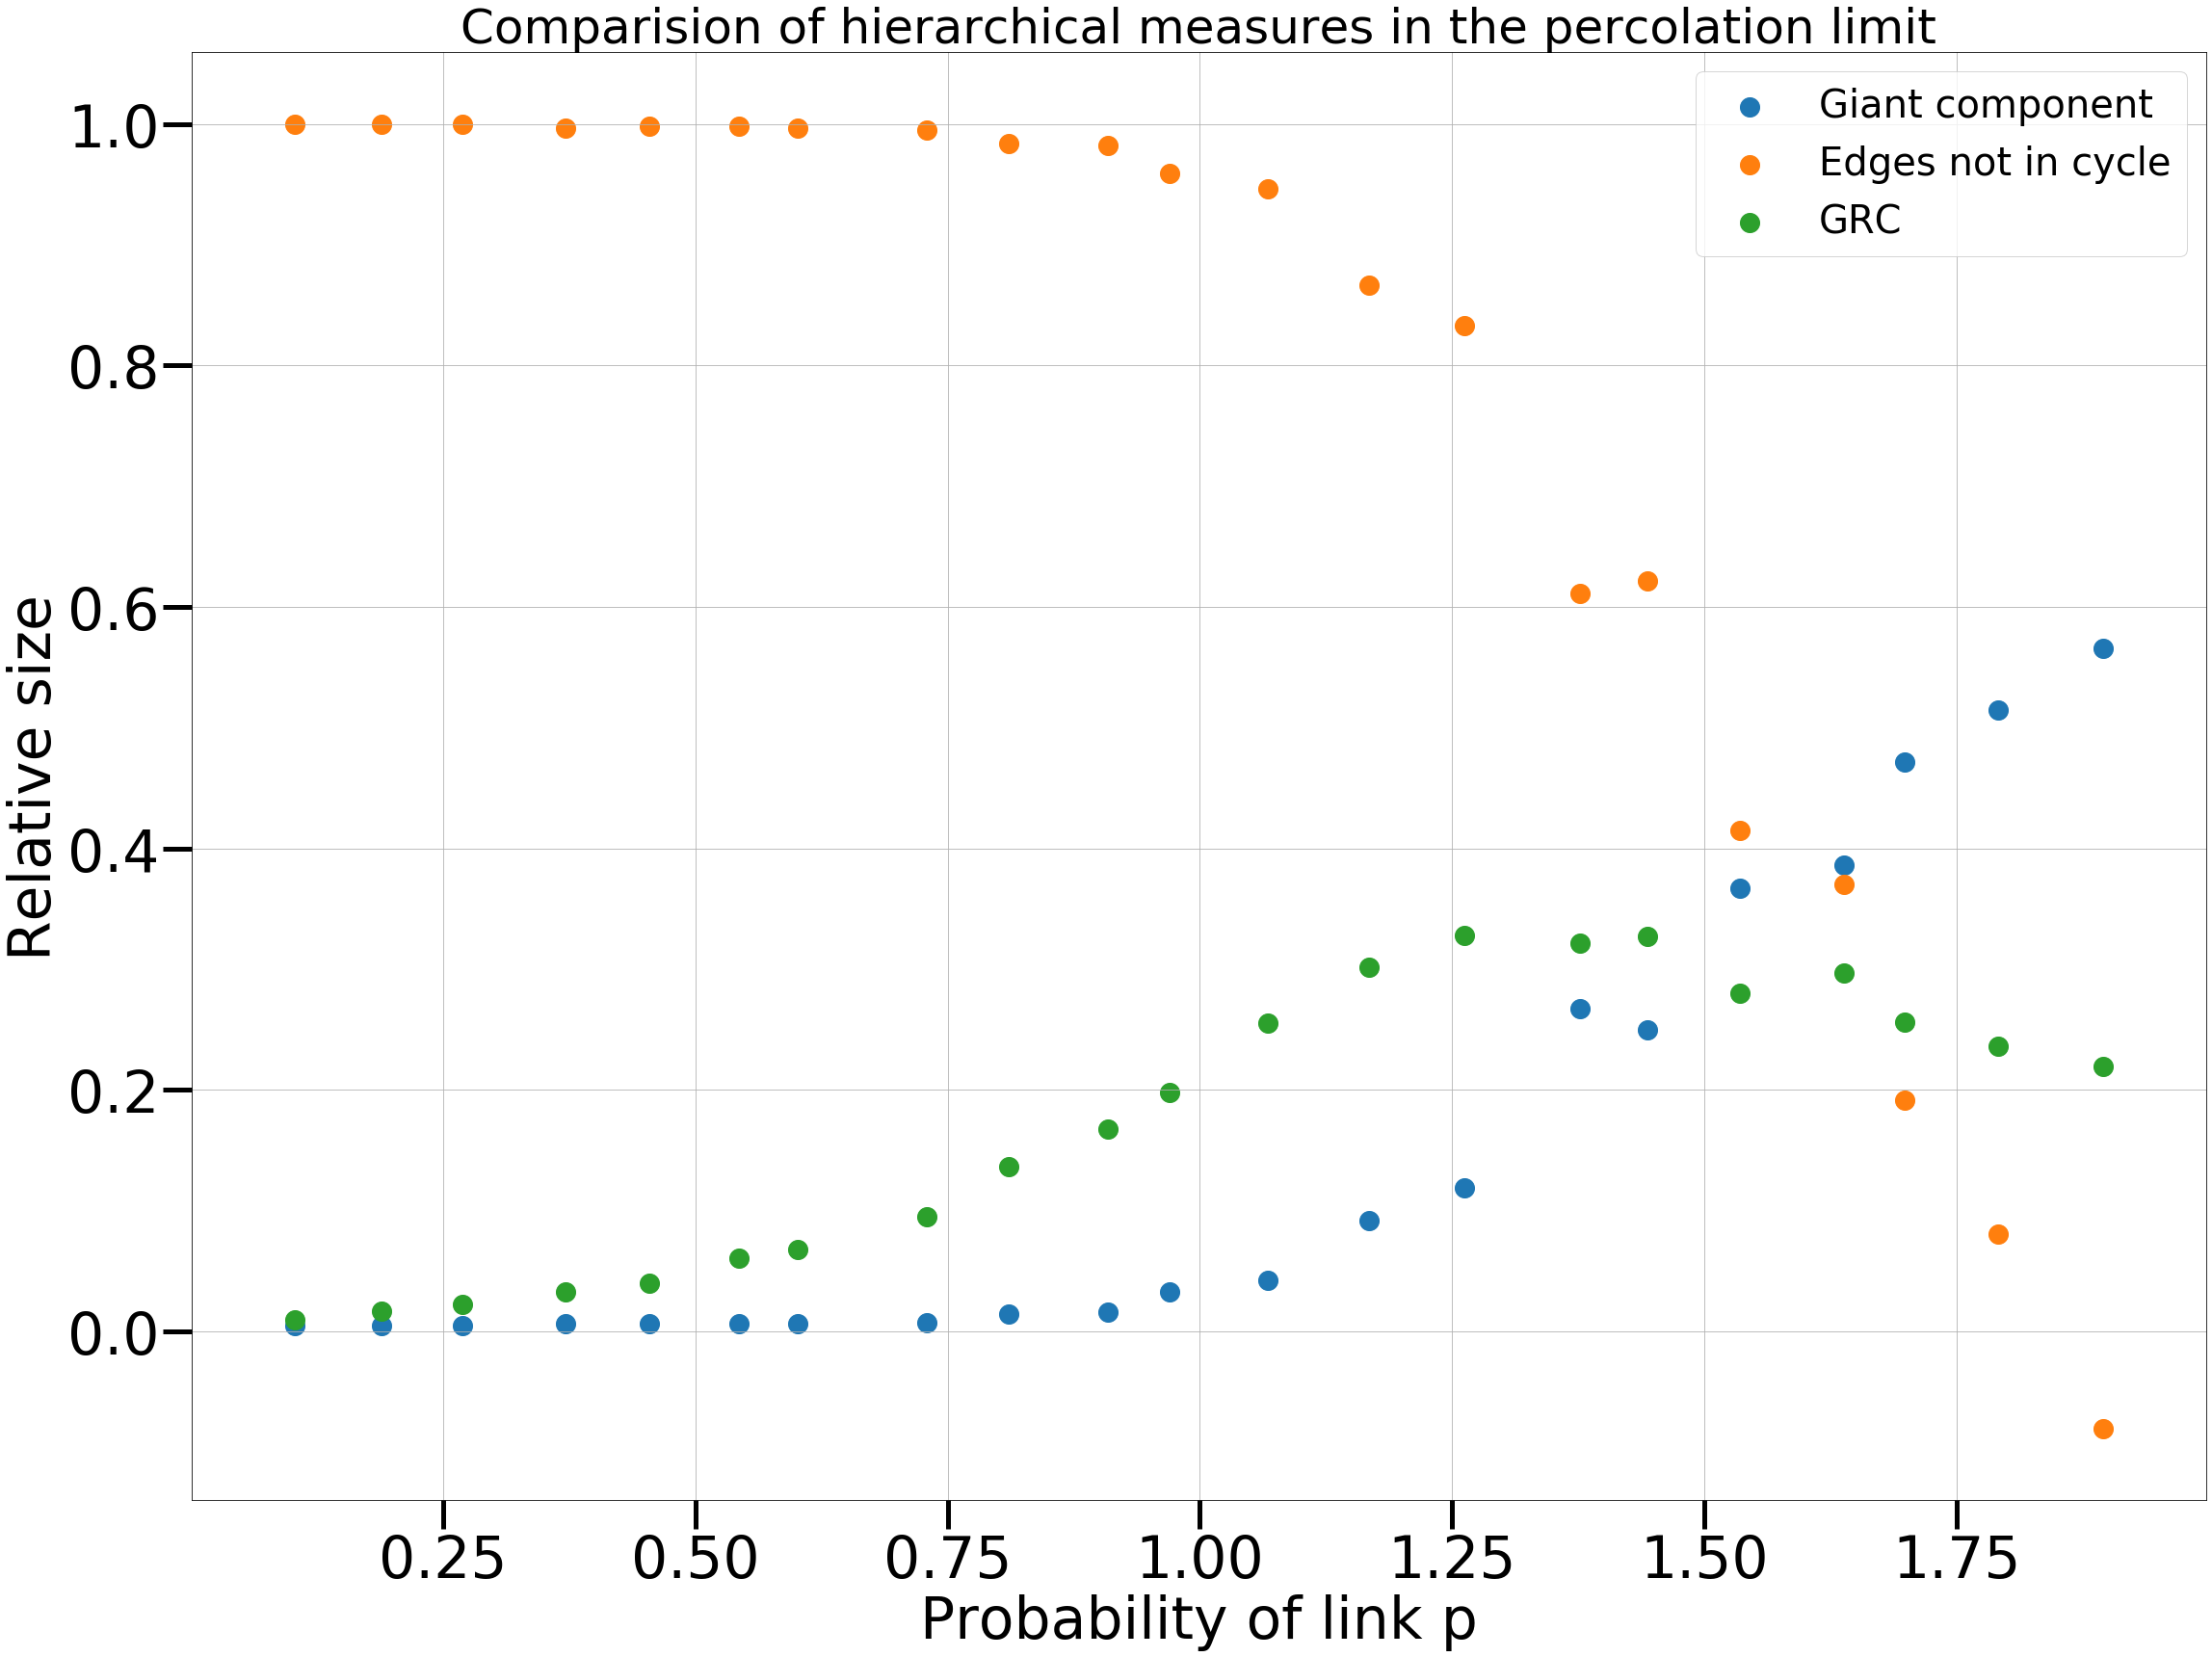

In [43]:
fig,ax=plt.subplots(figsize=(32,24))
ax.set_title('Comparision of hierarchical measures in the percolation limit',fontsize=50)
ax.set_xlabel('Probability of link p',fontsize=60)
ax.set_ylabel('Relative size',fontsize=60)
ax.grid(True)
ax.tick_params(axis='both',labelsize=60,length=30,width=5)
ax.scatter(mean_d,rel_s,label = 'Giant component',s=400)
ax.scatter(mean_d,ed_no_cycle,label = 'Edges not in cycle',s=400)
ax.scatter(mean_d,glo_cen,label='GRC',s=400)
ax.legend(fontsize=40,markerscale=1)
fig.tight_layout()
#fig.savefig(os.path.join(out_path_var,fig_loop),bbox_inches='tight',format='png')

### Discussion of the measures
* Why the peak for the global reaching centrality is *shifted*?